<a href="https://colab.research.google.com/github/bongkyunSON/Deep_Leaning/blob/main/Prophet_case3_221212.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Electricity Supply and Demand Forecasting Using FbProphet

Electricity demand and supply forcasting is an important part of seemless power management and business as well. For example, during the Summer, the demand for ari conditioner and other electrci equipments increase, and thus the electricity use and demand. Thus, predicting it has great economic importance as well.

Description of the dataset

Date range: 1 January 2015 - 6 October 2020. 

*** Description of columns. ***

* date : datetime, the date of the recording
* demand : float, a total daily electricity demand in MWh
* RRP : float, a recommended retail price in
* demand_pos_RRP : float, a total daily demand at positive RRP in MWh
* RRP_positive : float, an averaged positive RRP, weighted by the corresponding intraday demand in 
* demand_neg_RRP : float, an total daily demand at negative RRP in MWh
* RRP_negative : float, an average negative RRP, weighted by the corresponding * intraday demand in 
* frac_at_neg_RRP : float, a fraction of the day when the demand was traded at negative RRP
* min_temperature : float, minimum temperature during the day in Celsius
* max_temperature : float, maximum temperature during the day in Celsius
* solar_exposure : float, total daily sunlight energy in MJ/m^2
rainfall : float, daily rainfall in mm
* school_day : boolean, if students were at school on that day
* holiday : boolean, if the day was a state or national holiday
* unit = AUD$ / MWh



In [6]:
# install relevant, necessary packages
!pip install pandas
!pip install numpy
!pip install prophet
!pip install plotnine

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [7]:
# import necessary libraries
import numpy as np # linear algebra
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
import warnings
warnings.filterwarnings('ignore')  # Hide warnings
warnings.simplefilter(action = "ignore", category = RuntimeWarning)
import datetime as dt
import pandas as pd
pd.core.common.is_list_like = pd.api.types.is_list_like
import pandas_datareader.data as web
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
import pandas as pd
from plotnine import *
import io
# we'll use the statistics package to conduct some predictive analytics
import statistics as st
%matplotlib inline
import matplotlib.dates as mdates
from pandas import DataFrame
from pandas import to_datetime
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.stattools import adfuller
from  sklearn.metrics import mean_absolute_error

In [8]:
# Let's convert the datafile into a dataframe
#  encoding='latin-1'
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/DeepLearning/prophet_강의/data/electricity_complete_dataset.csv') # important to specify encoding

In [9]:
# check total number of cells, first few rows, and descriptive stats 
def descriptive_info(df):
  number_of_cells = df.count(axis=0, level=None, numeric_only=False)
  print('Total number of cells the datafile has: \n' + str(number_of_cells))
  print('\n')
  print('Printing descriptive statistics...\n\n', df.describe())

In [10]:
# Let's check the shape of the dataset
# df.shape(0) for row numbers, # df.shape(1) for column numbers
print('Features:', df.shape[1],';', 'Entries:', df.shape[0]) 

Features: 14 ; Entries: 2106


We see that our intended feature 'demand' and date have no missing values. That's a happy news. Let's continue to check some descriptive stats....

In [11]:
# then, we need to check for missing values, especially if that's too high, we'll need to take care of it
(df.isnull().sum()/ df.shape[0]).sort_values(ascending=False)

rainfall           0.001425
solar_exposure     0.000475
date               0.000000
demand             0.000000
RRP                0.000000
demand_pos_RRP     0.000000
RRP_positive       0.000000
demand_neg_RRP     0.000000
RRP_negative       0.000000
frac_at_neg_RRP    0.000000
min_temperature    0.000000
max_temperature    0.000000
school_day         0.000000
holiday            0.000000
dtype: float64

In [12]:
# Let's check some descriptive stats of our dataset
descriptive_info(df)

Total number of cells the datafile has: 
date               2106
demand             2106
RRP                2106
demand_pos_RRP     2106
RRP_positive       2106
demand_neg_RRP     2106
RRP_negative       2106
frac_at_neg_RRP    2106
min_temperature    2106
max_temperature    2106
solar_exposure     2105
rainfall           2103
school_day         2106
holiday            2106
dtype: int64


Printing descriptive statistics...

               demand          RRP  demand_pos_RRP  RRP_positive  \
count    2106.000000  2106.000000     2106.000000   2106.000000   
mean   120035.476503    76.079554   119252.305055     76.553847   
std     13747.993761   130.246805    14818.631319    130.114184   
min     85094.375000    -6.076028    41988.240000     13.568986   
25%    109963.650000    38.707040   109246.250000     39.117361   
50%    119585.912500    66.596738   119148.082500     66.869058   
75%    130436.006250    95.075012   130119.477500     95.130181   
max    170653.840000  4549.645105  

In [13]:
# before proceeding any further let's make a copy of our original data file
df2 = df.copy()
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2106 entries, 0 to 2105
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   date             2106 non-null   object 
 1   demand           2106 non-null   float64
 2   RRP              2106 non-null   float64
 3   demand_pos_RRP   2106 non-null   float64
 4   RRP_positive     2106 non-null   float64
 5   demand_neg_RRP   2106 non-null   float64
 6   RRP_negative     2106 non-null   float64
 7   frac_at_neg_RRP  2106 non-null   float64
 8   min_temperature  2106 non-null   float64
 9   max_temperature  2106 non-null   float64
 10  solar_exposure   2105 non-null   float64
 11  rainfall         2103 non-null   float64
 12  school_day       2106 non-null   object 
 13  holiday          2106 non-null   object 
dtypes: float64(11), object(3)
memory usage: 230.5+ KB


In [14]:
# Now, let's prepare our dataset for forecasting 
# we'll define a function to do that. But before that,
# let's have a quick pick at our data
df2.head()


,date,demand,RRP,demand_pos_RRP,RRP_positive,demand_neg_RRP,RRP_negative,frac_at_neg_RRP,min_temperature,max_temperature,solar_exposure,rainfall,school_day,holiday
0,2015-01-01,99635.030,25.633696,97319.240,26.415953,2315.790,-7.240000,0.020833,13.3,26.9,23.6,0.0,N,Y
1,2015-01-02,129606.010,33.138988,121082.015,38.837661,8523.995,-47.809777,0.062500,15.4,38.8,26.8,0.0,N,N
2,2015-01-03,142300.540,34.564855,142300.540,34.564855,0.000,0.000000,0.000000,20.0,38.2,26.5,0.0,N,N
3,2015-01-04,104330.715,25.005560,104330.715,25.005560,0.000,0.000000,0.000000,16.3,21.4,25.2,4.2,N,N
4,2015-01-05,118132.200,26.724176,118132.200,26.724176,0.000,0.000000,0.000000,15.0,22.0,30.7,0.0,N,N


In [15]:
## function to Plot the dependent variable vs time

def _fig_plot(df, X, Y):
  ''' Function plots the data. requires to provide dataframe in the
  format of date as ds, observation as y, Preset other variables e.g., axis name
  '''
  df.plot(x = X, y = Y, figsize=Figsize, label = Label)
  plt.xlabel(xAxisLabel, fontsize = 16)
  plt.ylabel(yAxisLabel, fontsize = 16)
  plt.legend()
  plt.title(Title, fontsize = 20)
  ax = plt.gca().get_xaxis()

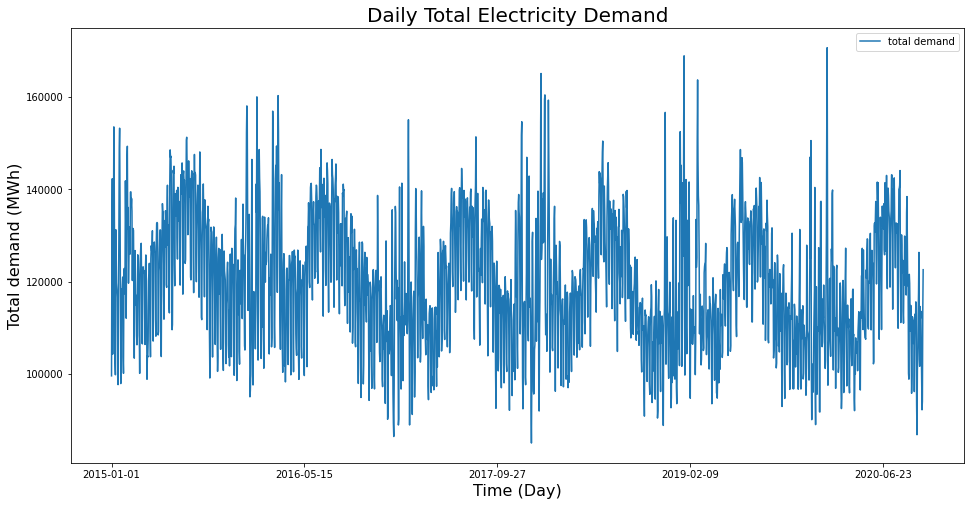

In [16]:
# provide variable names and other required inputs to plot using the function
X = 'date' # the date variable
Y = 'demand' # predicted variable
Label = "total demand"
Figsize = (16,8)
Title = "Daily Total Electricity Demand"
xAxisLabel = 'Time (Day)'
yAxisLabel = 'Total demand (MWh)'
_fig_plot(df2, X, Y)

The plotted data shows daily,monthly and yearly seasonality. We need to keep that in mind when fitting our model. 
Now, let's prepare our data for prediction.

In [17]:
# This Function is to prepare the dataset for Fb Prophet
#ds, save the name of date column as ds
#y, save the name of column we are interested in as y
def prepare_data(df, ds, y):
  '''
  input: df = dataframe
  ds = date column
  y = prediction column
  '''
  df = df[[ds, y]]
  df = df.rename(columns={ds: "ds", y: "y"}) #now it is usable for FB Prophet, let's check the new file
  print('The series is ready for use.\n')
  return df

In [18]:
# Use the function to prepare the dataframe to feed into fbprophet
# df = series, ds = the time variable name from the dataframe (string), 
# y = intended variable name for prediction from the dataframe, (string)
df3 = prepare_data(df2, ds = 'date', y = 'demand') 
print(df3.head())
print('')
print('The length of your series is: ', len(df3))

The series is ready for use.

           ds           y
0  2015-01-01   99635.030
1  2015-01-02  129606.010
2  2015-01-03  142300.540
3  2015-01-04  104330.715
4  2015-01-05  118132.200

The length of your series is:  2106


In [19]:
# if interested can be used the built in holidays
import holidays 
holiday = pd.DataFrame([])
for date, name in sorted(holidays.AU(years=[2015,2016,2017,2018,2019,2020]).items()):
    holiday = holiday.append(pd.DataFrame({'ds': date, 'holiday': "AUS-Holidays"}, index=[0]), ignore_index=True)
holiday['ds'] = pd.to_datetime(holiday['ds'], format='%Y-%m-%d', errors='ignore')

In [20]:
# we can either create test dataset, and remove last 100 days
# or can simply train the model on the complete dataset and predict 
# electricity demand in the future dates
train = df3[:]
#test = df3[2000:]

In [21]:
# let's predict now
# instantiate the model and fit the timeseries

prophet = Prophet(daily_seasonality=False,
                  growth='linear', 
                  changepoints=None, 
                  n_changepoints=25, 
                  changepoint_range=0.8, 
                  yearly_seasonality=True, 
                  weekly_seasonality=True, 
                  seasonality_mode='additive', 
                  seasonality_prior_scale=10, 
                  holidays_prior_scale=10, 
                  changepoint_prior_scale=0.05, 
                  mcmc_samples=0, 
                  interval_width=0.8, 
                  uncertainty_samples=1000, 
                  stan_backend=None)
prophet.fit(train)

# create a future data frame 
future = prophet.make_future_dataframe(periods=100)
forecast = prophet.predict(future)

DEBUG:cmdstanpy:input tempfile: /tmp/tmpd6327xim/5bq4opul.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpd6327xim/zwyr4l2i.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=56972', 'data', 'file=/tmp/tmpd6327xim/5bq4opul.json', 'init=/tmp/tmpd6327xim/zwyr4l2i.json', 'output', 'file=/tmp/tmpd6327xim/prophet_modelntxqqr5d/prophet_model-20221231113114.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:31:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:31:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Printing outputs from Prophet prediction...
           ds           yhat     yhat_lower     yhat_upper
0 2015-01-01  122846.313526  111889.370692  134143.452805
1 2015-01-02  121132.203387  109831.493256  132471.320071
2 2015-01-03  108347.246310   97726.166201  119361.139782
3 2015-01-04  104654.230781   94142.217483  115908.158785
4 2015-01-05  119906.110748  108434.835556  130910.839926


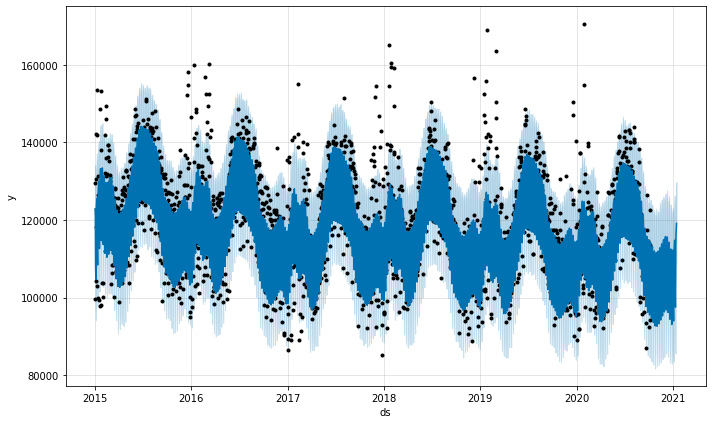

In [22]:
# summarize the forecast
print('Printing outputs from Prophet prediction...\n', forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head())
# plot forecast
prophet.plot(forecast)
plt.show()

In [23]:
# Python
plot_plotly(prophet, forecast)

In [24]:
print(len(forecast), len(train), len(df3))

2206 2106 2106


This following section can be used when we keep some data for testing. If we continue with the full dataset, Prophet built in evaluation methond is good enough for evaluation.

In [25]:
#print('Length of forcast series, train series, and original series: ', len(forecast), len(train), len(df2))
#print(' ')
#y_true= test['y'].values
#y_pred = forecast['yhat'][:len(y_true)].values
#mae = mean_absolute_error(y_true, y_pred)
#print('Mean Absolute Error: %.3f' % mae)

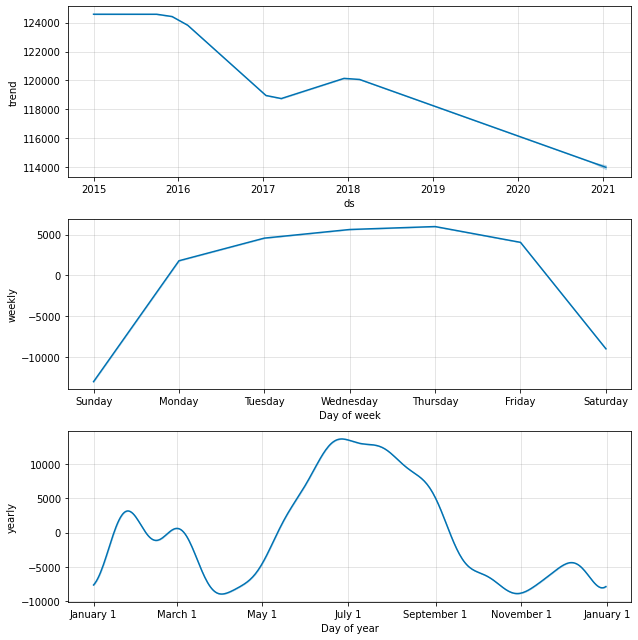

In [26]:
# plot the components of forcasted series
fig2 = prophet.plot_components(forecast)
plt.show()

In [27]:
# Now, let's use the built in fbprophet evaluation function and metrix

evaluation_model = cross_validation(prophet, initial='1800 days', period='50 days', horizon = '25 days')

INFO:prophet:Making 6 forecasts with cutoffs between 2020-01-05 00:00:00 and 2020-09-11 00:00:00


  0%|          | 0/6 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpd6327xim/61dk_7eq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpd6327xim/2yjq7py4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=20279', 'data', 'file=/tmp/tmpd6327xim/61dk_7eq.json', 'init=/tmp/tmpd6327xim/2yjq7py4.json', 'output', 'file=/tmp/tmpd6327xim/prophet_model8k7uyxye/prophet_model-20221231113156.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:31:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:31:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpd6327xim/p7yy67re.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpd6327xim/hhq8ivt0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/l

In [28]:
evaluation_metrix = performance_metrics(evaluation_model)
evaluation_metrix.head(5)

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,3 days,7.949195e+07,8915.825950,8090.002429,0.070787,0.068191,0.069667,0.800000
1,4 days,8.423653e+07,9178.046013,8598.807423,0.074893,0.072791,0.074231,0.766667
2,5 days,6.069772e+07,7790.874074,7014.401831,0.061944,0.070941,0.061624,0.866667
3,6 days,4.911352e+07,7008.104203,5839.127915,0.052290,0.047954,0.051789,0.833333
4,7 days,5.051796e+07,7107.598575,5594.449025,0.051131,0.035291,0.049875,0.800000
